<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/concrete_crack_detection_rank_3_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import skimage.exposure
import os

In [ ]:
!unzip "/content/drive/MyDrive/concrete_cracked_images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: concrete_cracked_images/train/Positive/15001_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15002_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15003_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15004_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15005_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15006_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15007_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15008_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15009_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15010_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15011_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15012_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15013_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15014_1.jpg  
  inflating: concrete_cra

In [ ]:
from os import listdir as ld
print("negative images:", len(ld("/content/concrete_cracked_images/train/Negative")))
print("posivite images:", len(ld("/content/concrete_cracked_images/train/Positive")))

negative images: 13818
posivite images: 14900


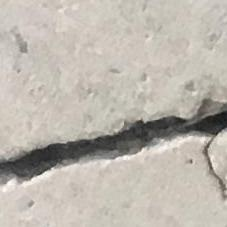

In [ ]:
image=cv2.imread("concrete_cracked_images/train/Positive/19921.jpg")
cv2_imshow(image)

In [ ]:
image.shape

(227, 227, 3)

In [ ]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.15)

In [ ]:
train_generator=datagen.flow_from_directory(
    directory="/content/concrete_cracked_images/train",
    target_size=(224,224),
    color_mode="rgb",
    subset="training",
    class_mode="binary",
    batch_size=32,
    shuffle=True)

Found 24411 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'Negative': 0, 'Positive': 1}

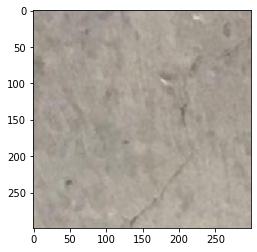

In [ ]:
x,y = train_generator.next()
for i in range(8,9):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [ ]:
valid_generator=datagen.flow_from_directory(
    directory="/content/concrete_cracked_images/train",
    target_size=(224,224),
    color_mode="rgb",
    subset="validation",
    class_mode="binary",
    batch_size=32,
    shuffle=True)

Found 4307 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,ResNet152V2,EfficientNetB7, MobileNetV2,Xception,ResNet101V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.CenterCrop(224,224),
    ]
)

In [ ]:

resnet=ResNet50(weights="imagenet",)

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
x=resnet.layers[-2].output
fc1=Dense(1,activation='sigmoid',kernel_initializer='glorot_uniform', kernel_regularizer=l2(.0005))(x)
my_model=Model(inputs=resnet.input,outputs=fc1)

In [ ]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
my_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),metrics=["accuracy"],loss= tf.keras.losses.BinaryCrossentropy())

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
my_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=1,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID)

762/762 [==============================] - 275s 361ms/step - loss: 0.2028 - accuracy: 0.9998 - val_loss: 0.2040 - val_accuracy: 0.9993


In [ ]:
test=pd.read_csv("/content/concrete_cracked_images/Testing_set_concrete_crack.csv")
sub=pd.read_csv("/content/concrete_cracked_images/sample_submission.csv")

In [ ]:
test_generator=datagen.flow_from_dataframe(
dataframe=test,
directory="/content/concrete_cracked_images/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(256,256))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 11282 validated image filenames.


In [ ]:
pred1=(my_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1))

11282/11282 [==============================] - 104s 9ms/step


In [ ]:
sm=pd.DataFrame(pred1)
sm.to_csv("res50_256_dphi.csv",index=False)

In [ ]:
pred1

array([[0.04460395],
       [0.06089988],
       [0.0917295 ],
       ...,
       [0.04497629],
       [0.89492995],
       [0.06758571]], dtype=float32)

In [ ]:
pred=[]
for i in pred1:
  if (i<0.5): pred.append(0)
  else: pred.append(1)

In [ ]:
sub["prediction"]=pred
sub["prediction"]=sub["prediction"].map({0:"Negative",1:"Positive"})

In [ ]:
sub.prediction.value_counts()

Negative    6188
Positive    5094
Name: prediction, dtype: int64

In [ ]:
sub.to_csv("8.csv",index=False)

In [ ]:
res50=pd.read_csv("/content/res50_dphi.csv")
res101=pd.read_csv("/content/res101_dphi.csv")

In [ ]:
sub=(0.4*res50+0.6*res101)

In [ ]:
pred=[]

for i in sub["0"]:
  if (i<0.5): pred.append(0)
  else: pred.append(1)

In [ ]:
sub.drop("0",axis=1,inplace=True)

In [ ]:
sub.to_csv("3.csv",index=False)